In [12]:
from datetime import datetime
import pandas as pd
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
log_file_path = "log.txt"
file_id = '1BflTXiRn1I7SJONpAJjTaw1e8YHvZwZ2'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
file_path = "C:/Users/alaha/Documents/GitHub/Projects/Selerix_Automation/output.xlsx"

# Triggering and updating source file

In [3]:
def cloud_file():
    response = requests.get(url)
    df_new = pd.read_excel(BytesIO(response.content), sheet_name=None)

    return df_new


In [4]:
def local_file():
    df= pd.read_excel(file_path, sheet_name=None)

    return df

In [5]:
import pandas as pd

def compare_excels(file1, file2):
    dfs1 = file1
    dfs2 = file2

    sheets1 = set(dfs1.keys())
    sheets2 = set(dfs2.keys())
    common_sheets = sheets1.intersection(sheets2)

    differences = {}

    for sheet in common_sheets:
        df1 = dfs1[sheet].fillna('').astype(str)
        df2 = dfs2[sheet].fillna('').astype(str)

        if df1.shape != df2.shape:
            differences[sheet] = f"Different shape: {df1.shape} vs {df2.shape}"
            continue

        # Find EID column if present
        eid_col = next((col for col in df1.columns if col.strip().lower() in ['eid', 'employee id']), None)

        diff_cells = []
        for row in range(df1.shape[0]):
            for col in range(df1.shape[1]):
                val1 = df1.iat[row, col]
                val2 = df2.iat[row, col]
                if val1 != val2:
                    diff_entry = {
                        'Row': row + 2,
                        'Column': df1.columns[col],
                        'Original': val1,
                        'Modified': val2
                    }
                    if eid_col:
                        diff_entry['EID'] = df1.at[row, eid_col]
                    diff_cells.append(diff_entry)

        if diff_cells:
            differences[sheet] = pd.DataFrame(diff_cells)

    return differences


In [6]:
def log_differences(df, df_new):
    diffs = compare_excels(df, df_new)
    for sheet, diff in diffs.items():
        print(f"\n--- Differences in sheet: {sheet} ---")
        if isinstance(diff, pd.DataFrame):
            print(diff)
        else:
            print(diff)
            
    with open(log_file_path, "a", encoding="utf-8") as log_file:
        now = datetime.now()
        # log_file.write(now.to_string(index=False))
        print("Now:", now)
        log_file.write(f"\n----------------------------- Log recorded at {now}-----------------------------\n")
        for sheet, diff in diffs.items():
            log_file.write(f"\n--- Differences in sheet: {sheet} at {now}---\n")
            if isinstance(diff, pd.DataFrame):
                log_file.write(diff.to_string(index=False))
                log_file.write("\n")
            else:
                log_file.write(str(diff))
                log_file.write("\n")

        log_file.write(f"\n----------------------------------------------------------------------------------------------------------\n")


In [7]:
#swap df
def trigger_swap():
    df=local_file()
    df_new=cloud_file()
    log_differences(df, df_new)
    df=df_new
    with pd.ExcelWriter("output.xlsx") as writer:
        for sheet_name, sheet_df in df.items():
            sheet_df.to_excel(writer, sheet_name=sheet_name, index=False)

# Trigger Function

In [8]:
trigger_swap()


--- Differences in sheet: Current Benefits ---
   Row Column Original Modified   EID
0   13   Plan   Vision   Dental  5966

--- Differences in sheet: Employees ---
   Row Column  Original   Modified   EID
0    2  First    Warren     Jeremy  6159
1    2   Last    Wilson   Campbell  6159
2    3  First      Test     Brenda  9376
3    3   Last      Name  Hernandez  9376
4    6  First      Ivan     Warren  6321
5    6   Last      West     Wilson  6321
6   11   Last  Virinchi     Turner  7323
7   18   Last    Warren      Smith  1838
Now: 2025-06-08 15:16:52.462603


# EDA of the final data

In [9]:
xls = pd.ExcelFile(file_path)
all_sheets = {sheet: xls.parse(sheet) for sheet in xls.sheet_names}
for sheet in xls.sheet_names:
    df = xls.parse(sheet)
    csv_filename = f"{sheet.replace(' ', '_')}.csv"
    df.to_csv(f"individual/{csv_filename}", index=False)
    print(f"Saved: {csv_filename}")

Saved: Employees.csv
Saved: Spouse_&_Dependents.csv
Saved: Current_Benefits.csv
Saved: Benefit_Detail.csv
Saved: Beneficiaries.csv
Saved: Riders.csv
Saved: Answers.csv
Saved: Notes.csv
Saved: Payment_Info.csv
Saved: Pay_History.csv
Saved: Key.csv


## EDA of employees

In [10]:
emp_df=pd.read_csv("Individual/Employees.csv")
emp_df.head()

,Employee SSN,EID,Prefix,First,MI,Last,Suffix,DOB,Sex,Marital Status,...,Mailing Address 1,Mailing Address 2,Mailing City,Mailing State,Mailing Zip,Country of Citizenship,Event Code,Event Description,User ID,Birth Country
0,488-75-9484,6159,Mrs.,Jeremy,Q,Campbell,NaN,1989-12-25,M,Married,...,027 Richardson Manor,NaN,Cunninghambury,NY,53783,Canada,6757,Optimized bandwidth-monitored policy,jonesjose,India
1,232-66-6342,9376,Dr.,Brenda,Q,Hernandez,NaN,1978-12-06,M,Widowed,...,97524 Joshua Ways,NaN,West Adam,NY,28087,India,5164,Horizontal 4thgeneration open architecture,hendricksmariah,Germany
2,473-77-8228,9957,Misc.,Mario,M,Washington,NaN,2003-03-03,F,Single,...,7112 Alan Place,NaN,Beverlyside,TX,9097,UK,6680,Centralized scalable Local Area Network,crystal63,Canada
3,554-77-9569,5966,Mrs.,Heather,M,Baker,NaN,1974-04-15,F,Single,...,20334 Ashley Place Apt. 844,NaN,North Jennifer,CA,13391,Canada,6284,Triple-buffered dedicated protocol,pstephenson,USA
4,719-49-2910,6321,Dr.,Warren,R,Wilson,NaN,1973-05-27,M,Single,...,0464 Weber Manors,NaN,Brianshire,CA,27494,Germany,5805,Progressive non-volatile success,richard32,India


In [11]:
duplicate_eids = emp_df[emp_df.duplicated('EID', keep=False)]
print("🔁 Duplicate EIDs:")
print(duplicate_eids)

emp_df = emp_df.drop_duplicates(subset='EID', keep='first')



🔁 Duplicate EIDs:
   Employee SSN   EID Prefix    First MI     Last  Suffix         DOB Sex  \
21  072-01-9180  5747    Mr.    Karen  O   Thomas     NaN  1975-11-19   F   
25  148-83-9863  5747    Dr.  Richard  J  Jenkins     NaN  1967-07-28   M   

   Marital Status  ...              Mailing Address 1 Mailing Address 2  \
21        Married  ...  568 Thompson Manors Suite 209               NaN   
25         Single  ...             8105 Murphy Ridges               NaN   

    Mailing City Mailing State Mailing Zip  Country of Citizenship Event Code  \
21  North Julian            GA       92386                      UK       9985   
25    South Troy            CA        9528                  Canada       9976   

                Event Description       User ID Birth Country  
21   Virtual incremental leverage     charles75         India  
25  Multi-channeled 24/7 software  johnsonamber            UK  

[2 rows x 59 columns]


Shape: (99, 59)

Columns: ['Employee SSN', 'EID', 'Prefix', 'First', 'MI', 'Last', 'Suffix', 'DOB', 'Sex', 'Marital Status', 'Country', 'Address 1', 'Address 2', 'City', 'State', 'Zip', 'Home Phone', 'Mobile Phone', 'Work Phone', 'Email', 'Personal Email', 'Payroll Frequency', 'Deduction Frequency', 'Gross Salary', 'Location Number', 'Location', 'Job Class', 'Pay Group', 'Department Number', 'Department', 'Title', 'FTE', 'Hours Per Week', 'Hire date', 'Eligibility Date', 'Status', 'Enrollment Status', 'Termination date', 'Event date', 'PIN', 'Require PIN Change', 'As Of', 'Session UserID', 'Session City', 'Session State', 'Hourly Wage', 'PTO Balance', 'PTO Cost', 'Mailing Country', 'Mailing Address 1', 'Mailing Address 2', 'Mailing City', 'Mailing State', 'Mailing Zip', 'Country of Citizenship', 'Event Code', 'Event Description', 'User ID', 'Birth Country']

Data Types:
 Employee SSN               object
EID                         int64
Prefix                     object
First         

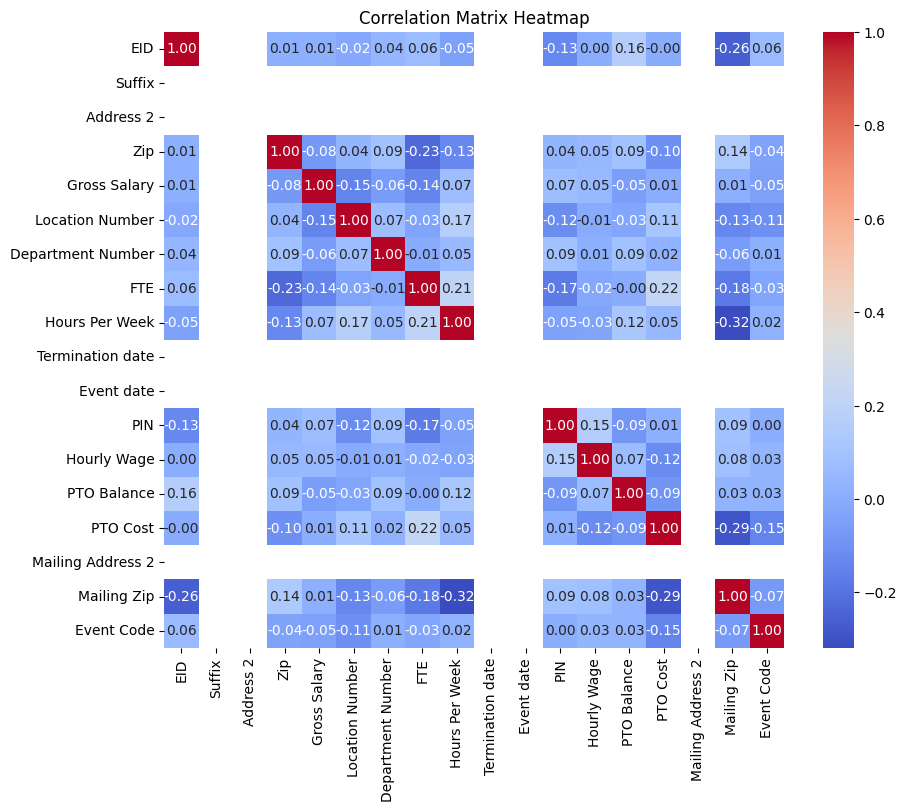


Sample rows:
   Employee SSN   EID Prefix    First MI        Last  Suffix         DOB Sex  \
0  488-75-9484  6159   Mrs.   Jeremy  Q    Campbell     NaN  1989-12-25   M   
1  232-66-6342  9376    Dr.   Brenda  Q   Hernandez     NaN  1978-12-06   M   
2  473-77-8228  9957  Misc.    Mario  M  Washington     NaN  2003-03-03   F   
3  554-77-9569  5966   Mrs.  Heather  M       Baker     NaN  1974-04-15   F   
4  719-49-2910  6321    Dr.   Warren  R      Wilson     NaN  1973-05-27   M   

  Marital Status  ...            Mailing Address 1 Mailing Address 2  \
0        Married  ...         027 Richardson Manor               NaN   
1        Widowed  ...            97524 Joshua Ways               NaN   
2         Single  ...              7112 Alan Place               NaN   
3         Single  ...  20334 Ashley Place Apt. 844               NaN   
4         Single  ...            0464 Weber Manors               NaN   

     Mailing City Mailing State Mailing Zip  Country of Citizenship  \
0  Cun

In [13]:
# Basic info
print("Shape:", emp_df.shape)
print("\nColumns:", emp_df.columns.tolist())
print("\nData Types:\n", emp_df.dtypes)
print("\nMissing Values:\n", emp_df.isnull().sum())

# Descriptive statistics for numeric columns
print("\nDescriptive Statistics (Numeric):\n", emp_df.describe())

# Descriptive statistics for object columns
print("\nDescriptive Statistics (Categorical):\n", emp_df.describe(include='object'))

# Check for duplicate EIDs (should be 0 now)
duplicate_eids = emp_df.index.duplicated().sum()
print(f"\nNumber of duplicate EIDs: {duplicate_eids}")

# Unique value counts for key categorical columns
categorical_cols = ['Sex', 'Marital Status', 'Country', 'Status', 'Enrollment Status', 'Job Class', 'Title']
for col in categorical_cols:
    if col in emp_df.columns:
        print(f"\nValue counts for {col}:\n", emp_df[col].value_counts())

# Correlation matrix for numeric columns
corr = emp_df.select_dtypes(include=['number']).corr()
print("\nCorrelation Matrix:\n", corr)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# Sample rows
print("\nSample rows:\n", emp_df.head())

emp_df.to_csv("Individual/Employees.csv", index=False)

In [121]:
emp_df.head()

,Employee SSN,EID,Prefix,First,MI,Last,Suffix,DOB,Sex,Marital Status,...,Mailing Address 1,Mailing Address 2,Mailing City,Mailing State,Mailing Zip,Country of Citizenship,Event Code,Event Description,User ID,Birth Country
0,488-75-9484,6159,Mrs.,Warren,Q,Wilson,NaN,1989-12-25,M,Married,...,027 Richardson Manor,NaN,Cunninghambury,NY,53783,Canada,6757,Optimized bandwidth-monitored policy,jonesjose,India
1,232-66-6342,9376,Dr.,Test,Q,Name,NaN,1978-12-06,M,Widowed,...,97524 Joshua Ways,NaN,West Adam,NY,28087,India,5164,Horizontal 4thgeneration open architecture,hendricksmariah,Germany
2,473-77-8228,9957,Misc.,Mario,M,Washington,NaN,2003-03-03,F,Single,...,7112 Alan Place,NaN,Beverlyside,TX,9097,UK,6680,Centralized scalable Local Area Network,crystal63,Canada
3,554-77-9569,5966,Mrs.,Heather,M,Baker,NaN,1974-04-15,F,Single,...,20334 Ashley Place Apt. 844,NaN,North Jennifer,CA,13391,Canada,6284,Triple-buffered dedicated protocol,pstephenson,USA
4,719-49-2910,6321,Dr.,Ivan,R,West,NaN,1973-05-27,M,Single,...,0464 Weber Manors,NaN,Brianshire,CA,27494,Germany,5805,Progressive non-volatile success,richard32,India
